In [1]:
import joblib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler

from scipy import stats
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [2]:
df = pd.read_csv('global_air_pollution_data.csv')
df.head()

,country_name,city_name,aqi_value,aqi_category,co_aqi_value,co_aqi_category,ozone_aqi_value,ozone_aqi_category,no2_aqi_value,no2_aqi_category,pm2.5_aqi_value,pm2.5_aqi_category
0,Russian Federation,Praskoveya,51,Moderate,1,Good,36,Good,0,Good,51,Moderate
1,Brazil,Presidente Dutra,41,Good,1,Good,5,Good,1,Good,41,Good
2,Italy,Priolo Gargallo,66,Moderate,1,Good,39,Good,2,Good,66,Moderate
3,Poland,Przasnysz,34,Good,1,Good,34,Good,0,Good,20,Good
4,France,Punaauia,22,Good,0,Good,22,Good,0,Good,6,Good


In [3]:
#check info()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23463 entries, 0 to 23462
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   country_name        23036 non-null  object
 1   city_name           23462 non-null  object
 2   aqi_value           23463 non-null  int64 
 3   aqi_category        23463 non-null  object
 4   co_aqi_value        23463 non-null  int64 
 5   co_aqi_category     23463 non-null  object
 6   ozone_aqi_value     23463 non-null  int64 
 7   ozone_aqi_category  23463 non-null  object
 8   no2_aqi_value       23463 non-null  int64 
 9   no2_aqi_category    23463 non-null  object
 10  pm2.5_aqi_value     23463 non-null  int64 
 11  pm2.5_aqi_category  23463 non-null  object
dtypes: int64(5), object(7)
memory usage: 2.1+ MB


xem tổng quan như tên các feat và thông tin các mẫu
 - tổng số lượng mẫu, tổng số lượng đặt trưng
 - xem rõ từng đặt trung thuộc kiểu dữ liệu gì và hiện tại có bao nhiêu giá trị, tức là có null hay không (null= tổng - hiện tại)

# chọn feat numberic và label xóa đi object

Đặc trưng địa lý:
- country_name và city_name:
    - Lý do loại bỏ: Nếu mô hình của bạn không cần tính đến yếu tố địa lý cụ thể mà chỉ tập trung vào chất lượng không khí thì các cột này có thể bỏ đi để giảm kích thước dữ liệu. Ngoài ra, city_name thường chứa nhiều giá trị duy nhất (unique) và có thể phức tạp khi mã hóa thành các biến số.

Đặc trưng chất lượng không khí tổng thể:
-   aqi_value và aqi_category:
    - Vì là biến mục tiêu cần giữ aqi_category (loại không khí) và có thể loại bỏ aqi_value (giá trị AQI).

Các chỉ số AQI theo chất khí riêng lẻ:
-    co_aqi_value, ozone_aqi_value, no2_aqi_value, pm2.5_aqi_value:
        -  Lý do giữ: Những đặc trưng này đại diện cho mức độ ô nhiễm của từng loại khí và giúp mô hình phân lớp chính xác hơn khi xem xét từng loại khí ảnh hưởng đến chất lượng không khí.

Danh mục chất lượng của từng loại khí:
 -   co_aqi_category, ozone_aqi_category, no2_aqi_category, pm2.5_aqi_category:
        - Lý do loại bỏ: Nếu bạn đã giữ các giá trị AQI riêng cho từng chất khí (co_aqi_value, ozone_aqi_value, v.v.), các đặc trưng phân loại này có thể được loại bỏ, tránh dư thừa thông tin khi mô hình có thể dựa vào giá trị AQI cụ thể thay vì danh mục.
Đề xuất chọn:
  -  Giữ lại: aqi_category, co_aqi_value, ozone_aqi_value, no2_aqi_value, pm2.5_aqi_value.Giữ aqi_category để làm biến mục tiêu cho bài toán phân lớp, và các *_aqi_value để mô hình có thể sử dụng dữ liệu chi tiết về nồng độ từng loại khí.
   - Có thể bỏ đi: country_name, city_name, aqi_value, co_aqi_category, ozone_aqi_category, no2_aqi_category, pm2.5_aqi_category.
    city_name và country_name có thể bỏ nếu không có giá trị địa lý cụ thể; aqi_value bỏ vì có aqi_category; và các *_aqi_category bỏ vì có thể dựa vào *_aqi_value để phân loại.

In [4]:
df = df[['aqi_category', 'co_aqi_value','no2_aqi_value','ozone_aqi_value', 'pm2.5_aqi_value']]
df.head()

,aqi_category,co_aqi_value,no2_aqi_value,ozone_aqi_value,pm2.5_aqi_value
0,Moderate,1,0,36,51
1,Good,1,1,5,41
2,Moderate,1,2,39,66
3,Good,1,0,34,20
4,Good,0,0,22,6


# xử lý null


In [5]:
count_null = df.isna().sum()
print(count_null)
print('trước khi xóa null: ', df.shape)
df = df.dropna()
print('sau khi xóa null: ', df.shape)

aqi_category       0
co_aqi_value       0
no2_aqi_value      0
ozone_aqi_value    0
pm2.5_aqi_value    0
dtype: int64
trước khi xóa null:  (23463, 5)
sau khi xóa null:  (23463, 5)


Vì sao phải xử lý null? ....
- có nhiều phương pháp xử lý null như 'abc', nhưng chọn xóa null vì 'abc'    
        - vì sao chọn xóa chứ không chọn phương pháp khác 'abc'

# xóa đi dữ liệu trùng 

In [6]:
print('before:', df.shape)
df = df.drop_duplicates().reset_index(drop=True)
print('after:', df.shape)

before: (23463, 5)
after: (17100, 5)


tại sao phải xử lý trùng ......?

# phân tích dữ liệu dạng object (tạm để lại)
chia theo 2 đặt điểm là địa lý và danh mục các loại
- 'country_name', 'city_name' 
- *_aqi_category

In [7]:
# # #check unique

# #country_name
# print(df['country_name'].unique(),'\nSum unique: ', len(df['country_name'].unique()))
# #city_name
# print(df['city_name'].unique(),'\nSum unique: ', len(df['city_name'].unique()) )

số lượng city ngang bằng  so với lượng dữ liệu có sẵn(23035), điều này có thể ảnh hưởng đến hiệu suất đào tạo nếu chúng ta phải mã hóa đặc điểm phân loại này thành các vectơ one-hot (ví dụ bằng cách sử dụng OneHotEncoder). sẽ không giúp ích gì nhiều trong mô hình 
Ngược lại, 'country' Số lượng country khá  tốt, vì vậy sử dụng country  thay vì [city] làm thông tin địa lý để tăng độ khái quát.


In [8]:
# drop column city
# df.drop("city_name", axis=1, inplace=True)

In [9]:
# #check tính nhất quán về kí tự và sự tồn của country 

# country = df['country_name'].unique()

# # sort them alphabetically and then take a closer look
# country.sort()
# country
# print(country)


# # kiểm tra xem mỗi một quốc gia có bao nhiêu mẫu 
# df['country_name'].value_counts()

# Phân tích dữ liệu số

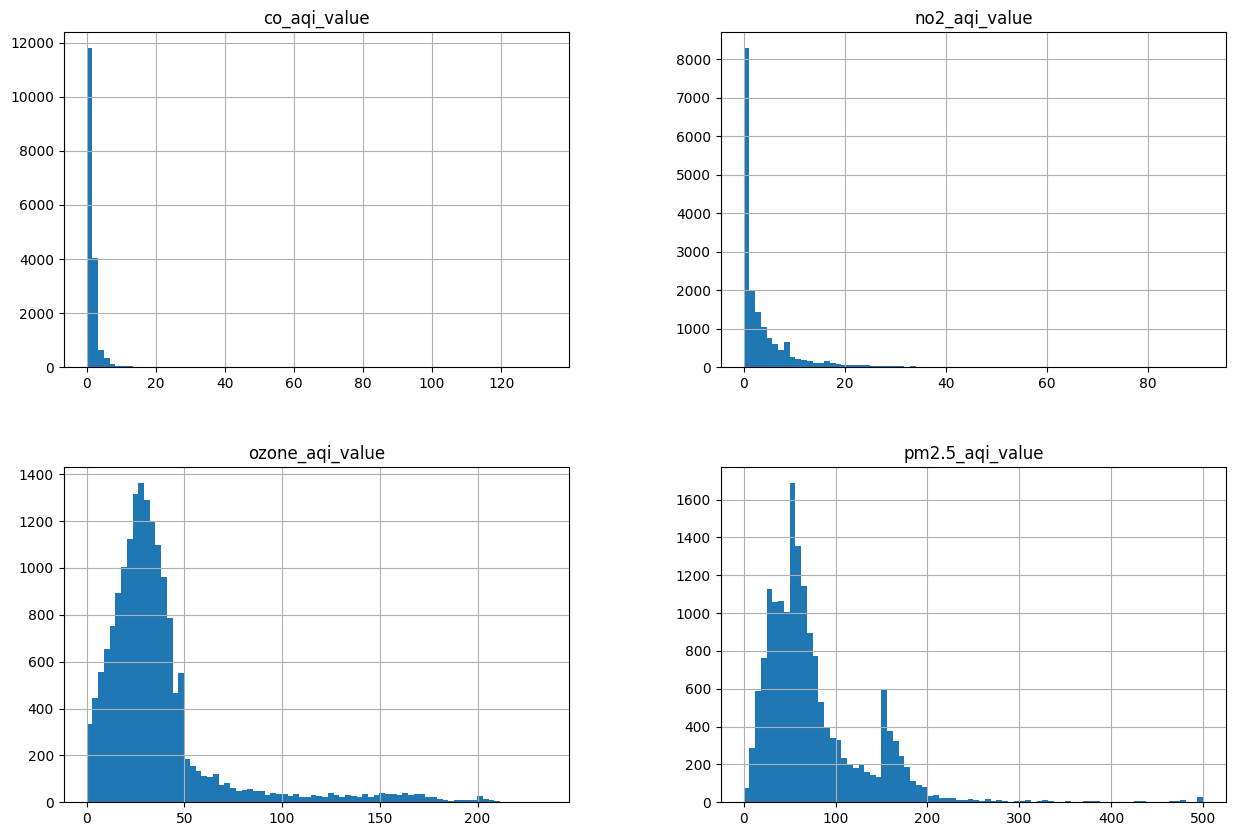

In [10]:
# histogram cho numberic
df.hist(bins=80, figsize=(15, 10))
plt.show() 

quan sát histogram nhận xét toàn dữ liệu nguyên dương 
- có phần phân bố không điều, lệch phải -> chuyển đổi dữ liệu Normalization
- có nhiều cách chuyển đổi như box-cox và 'abc' tại sao không dùng thằng khác? so sánh giải tích ....

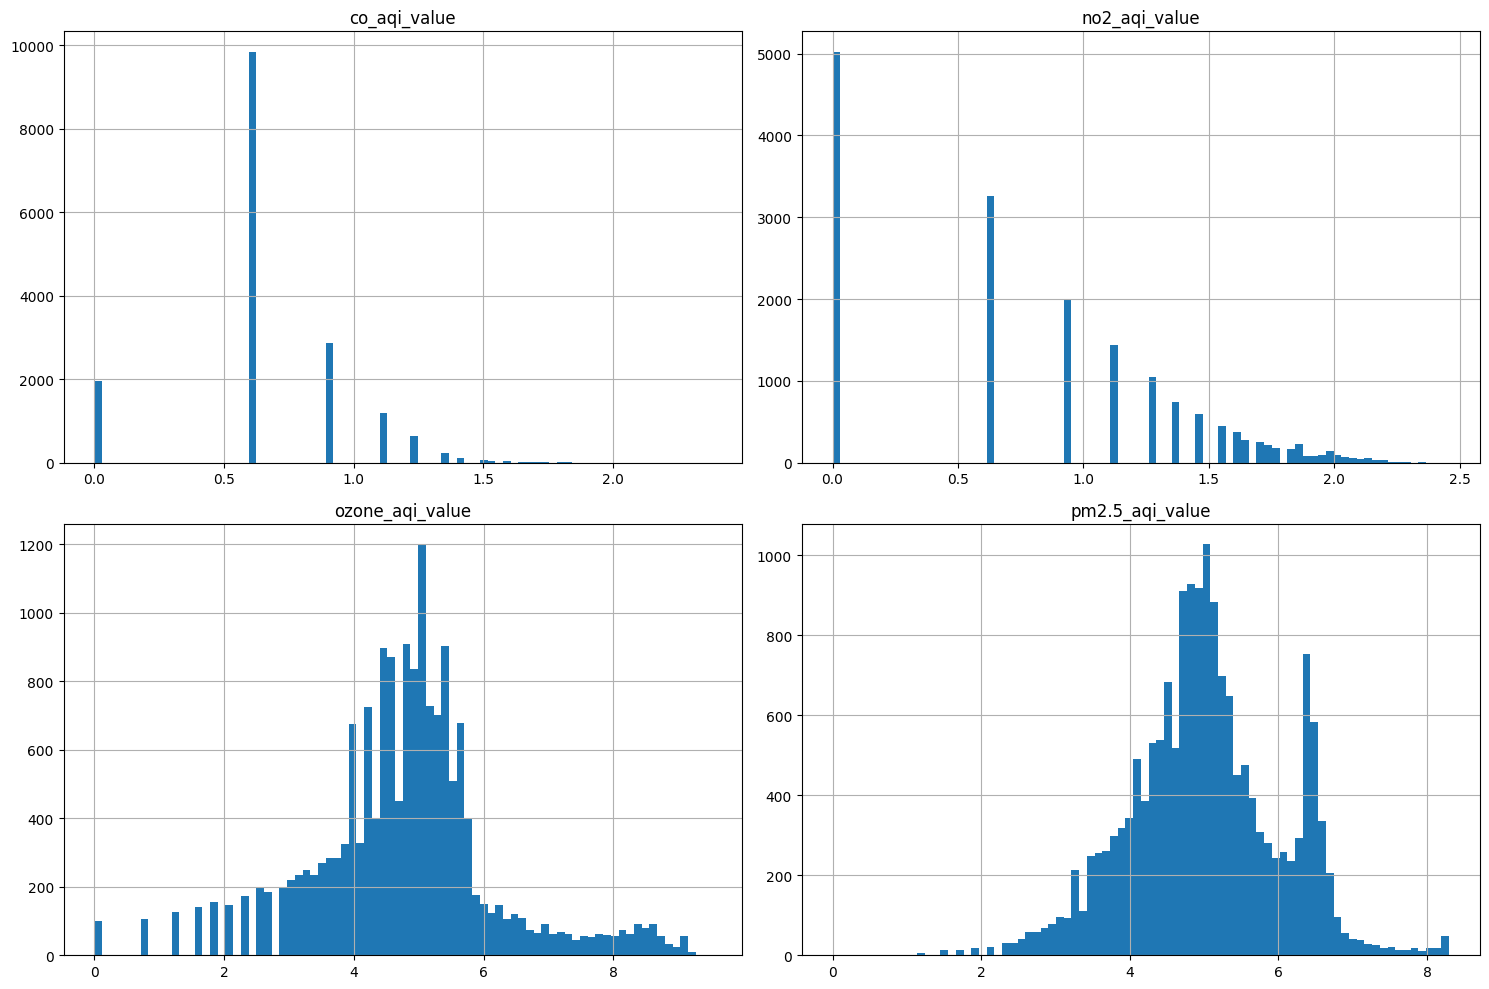

,aqi_category,co_aqi_value,no2_aqi_value,ozone_aqi_value,pm2.5_aqi_value
0,Moderate,0.617253,0.000000,5.156631,4.733618
1,Good,0.617253,0.624989,2.128238,4.433081
2,Moderate,0.617253,0.933984,5.310846,5.097745
3,Good,0.617253,0.000000,5.048073,3.496074
4,Good,0.000000,0.000000,4.263311,2.124252


In [ ]:
# Chọn các biến số để chuẩn hóa (loại bỏ nhãn 'aqi_category')
input_data = df[['co_aqi_value', 'no2_aqi_value', 'ozone_aqi_value', 'pm2.5_aqi_value']]

# Kiểm tra và điều chỉnh dữ liệu nếu có giá trị <= 0
input_data = input_data.apply(lambda x: x + 1 if (x <= 0).any() else x)

#Để lưu giá trị lambda sử dụng cho streamlit
lambda_values = []
for column in input_data.columns:
    _, lambda_value = stats.boxcox(input_data[column])
    lambda_values.append(lambda_value)

# Áp dụng Box-Cox transformation cho từng cột và lưu kết quả
normalized_data = input_data.apply(lambda x: stats.boxcox(x)[0])

# Gán lại các cột đã chuẩn hóa vào DataFrame ban đầu
df[['co_aqi_value', 'no2_aqi_value', 'ozone_aqi_value', 'pm2.5_aqi_value']] = normalized_data

joblib.dump(lambda_values, '../pickle/boxcox_lambda_values.pkl')

# Vẽ biểu đồ so sánh phân phối trước và sau khi chuẩn hóa
df.hist(bins=80, figsize=(15, 10))
plt.tight_layout()
plt.show()
df.head()

In [12]:
df.describe()

,co_aqi_value,no2_aqi_value,ozone_aqi_value,pm2.5_aqi_value
count,17100.000000,17100.000000,17100.000000,17100.000000
mean,0.684669,0.824024,4.754680,5.010925
std,0.336013,0.649655,1.425469,1.008814
min,0.000000,0.000000,0.000000,0.000000
25%,0.617253,0.000000,4.015443,4.399529
50%,0.617253,0.933984,4.814872,4.962000
75%,0.916135,1.381522,5.408506,5.628736
max,2.379212,2.457469,9.504692,8.298453


# kiểm tra tương quan của các biến numberic

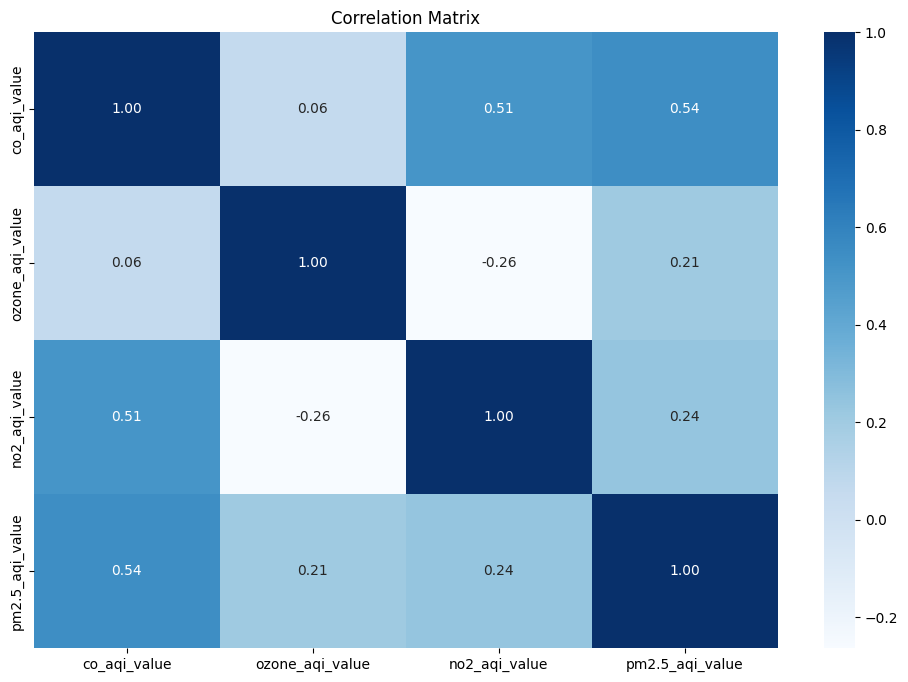

In [13]:
correlation_matrix = df[[ 'co_aqi_value', 'ozone_aqi_value', 'no2_aqi_value', 'pm2.5_aqi_value']].corr()

plt.figure(figsize=(12,8))
sns.heatmap(correlation_matrix, annot=True,cmap='Blues', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()


giải thích bảng tuogn quang trên <br>
giữ lại các thuộc tính trên, các cặp thuộc tính không có tương quan dương và âm trên 0.8 nên giữ, nếu >0.8 xóa đi vì .....

c:\Users\nhatt\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\axisgrid.py:2100: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


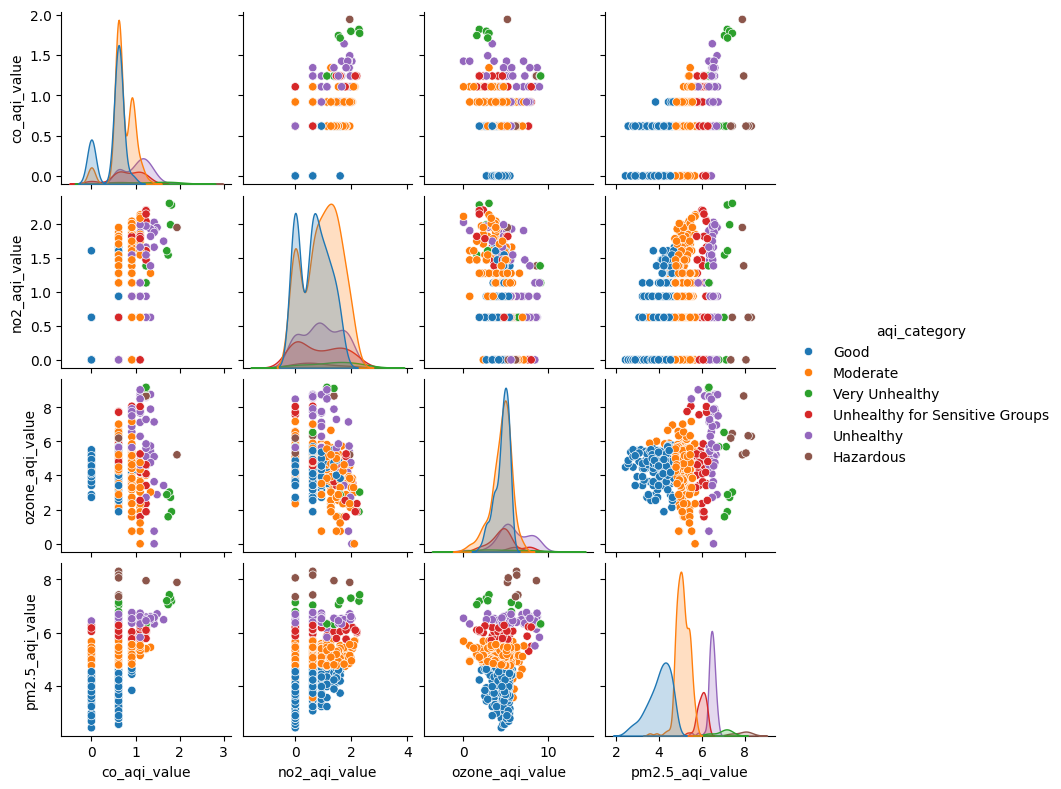

In [14]:
# vẽ pairplot với nhâu nhiên 500 maaux trong dataset
df_sample = df.sample(n=500, random_state=42)
palette = sns.color_palette("tab10", 6)
# Vẽ pair plot
sns.pairplot(data= df_sample,height=2, hue='aqi_category', palette=palette, size=2)
plt.show()

kiểm tra cân bằng dữ liệu

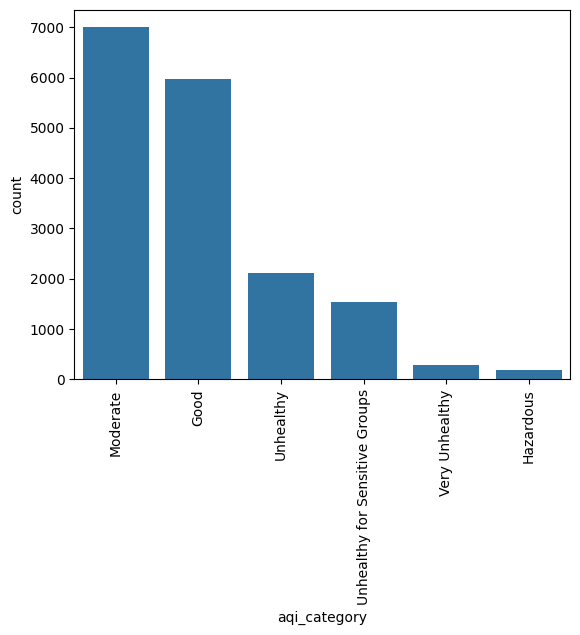

In [15]:
sns.barplot(df.iloc[:,0].value_counts())
plt.xticks(rotation = 90)
plt.show()

In [16]:
# df = df[~df['aqi_category'].isin(['Very Unhealthy', 'Hazardous'])].reset_index(drop=True)
# print(f'Data frame sau khi drop các dòng có aqi_category là Very Unhealthy hoặc Hazardous {df.shape}')

# convert label to numberic 


In [17]:
label_encoder = LabelEncoder()

df['aqi_category'] = label_encoder.fit_transform(df['aqi_category'])

# Hiển thị các nhãn và giá trị tương ứng sau khi chuyển đổi
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Mapping của các nhãn chữ sang số:", label_mapping)

df.head()

Mapping của các nhãn chữ sang số: {'Good': np.int64(0), 'Hazardous': np.int64(1), 'Moderate': np.int64(2), 'Unhealthy': np.int64(3), 'Unhealthy for Sensitive Groups': np.int64(4), 'Very Unhealthy': np.int64(5)}


,aqi_category,co_aqi_value,no2_aqi_value,ozone_aqi_value,pm2.5_aqi_value
0,2,0.617253,0.000000,5.156631,4.733618
1,0,0.617253,0.624989,2.128238,4.433081
2,2,0.617253,0.933984,5.310846,5.097745
3,0,0.617253,0.000000,5.048073,3.496074
4,0,0.000000,0.000000,4.263311,2.124252


# Chia tập dữ liệu 

In [18]:
# Đặt tỷ lệ chia dữ liệu
train_size = 0.7      # 70% cho training
val_size_relative = 2 / 3   # 20% của dữ liệu còn lại (30%) là validation => 2/3 của 30% 
test_size_relative = 1 / 3   # 10% của dữ liệu ban đầu là test => 1/3 của 30%

# Bước 1: Chia dữ liệu thành tập training và temporary (validation + test)
X_train, X_temp, y_train, y_temp = train_test_split(df.iloc[:,1:],df.iloc[:,0], test_size=1 - train_size, random_state=42)

# Bước 2: Chia temporary thành validation và test
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
X_test.head()

,co_aqi_value,no2_aqi_value,ozone_aqi_value,pm2.5_aqi_value
4606,0.617253,0.933984,7.181512,6.412681
11822,1.104462,1.272786,8.900737,6.226326
8097,0.916135,1.702605,5.048073,4.985446
7182,1.238322,1.602785,8.415132,6.342596
9336,0.617253,1.131234,5.209131,5.498713


kiểm tra cân bằng dữ liệu

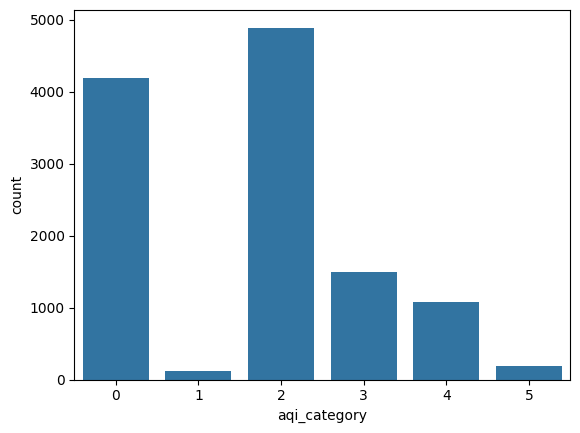

In [19]:
sns.barplot(y_train.value_counts())
plt.show()

# sử dung smote để cân bằng dữ liệu
tại sao không phải phương pháp khác có nhiều pp như up, down nhưng tại sao lại chọn pp này hãy trình bày cho phù hợp với bài toán <br>
dữ liệu ở mức nào thì mới nên upp  

Số lượng mẫu trong tập train của mỗi lớp sau khi áp dụng SMOTE:


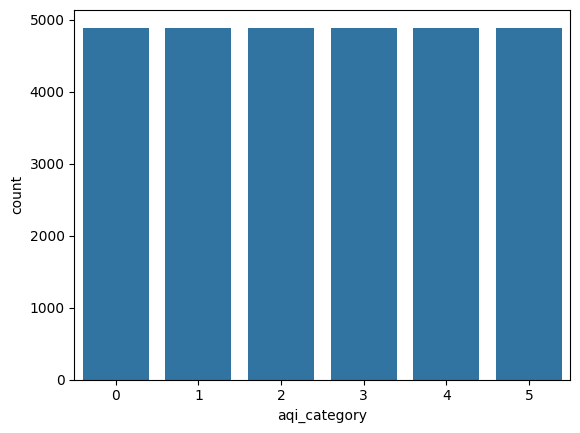

In [20]:
# Áp dụng SMOTE để cân bằng dữ liệu trên tập training
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

# Kiểm tra số lượng mẫu trong mỗi lớp sau khi SMOTE
print("Số lượng mẫu trong tập train của mỗi lớp sau khi áp dụng SMOTE:")
y_train.value_counts()
sns.barplot(y_train.value_counts())
plt.show()

# Scaling

chọn so sanhs 2 pp scaling và tại sao chọn phương pháp này nọ lọ chai giả tích phù hợp với bài toán

In [ ]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_val = scaler.transform(X_val)
joblib.dump(scaler, '../pickle/minmax_scaler.pkl')


['minmax_scaler.pkl']

# Train 

In [ ]:
# from softmax_function import SoftmaxRegression
from .GradientDecent.softmax_mini_batch import SoftmaxRegression
# Khởi tạo và huấn luyện mô hình
softmax_model = SoftmaxRegression(learning_rate=0.1, n_iter=300,batch_size= 16)
softmax_model.fit(X_train, y_train, X_val, y_val)
joblib.dump(softmax_model, '../pickle/softmax_model.pkl')

Epoch 0, Training Loss: 1.5554, Validation Loss: 1.4243, Training Acc: 0.4568, Validation Acc: 0.5306
Epoch 100, Training Loss: 0.5887, Validation Loss: 0.5303, Training Acc: 0.8474, Validation Acc: 0.8546
Epoch 200, Training Loss: 0.4994, Validation Loss: 0.4404, Training Acc: 0.8693, Validation Acc: 0.8784


['softmax_model.pkl']

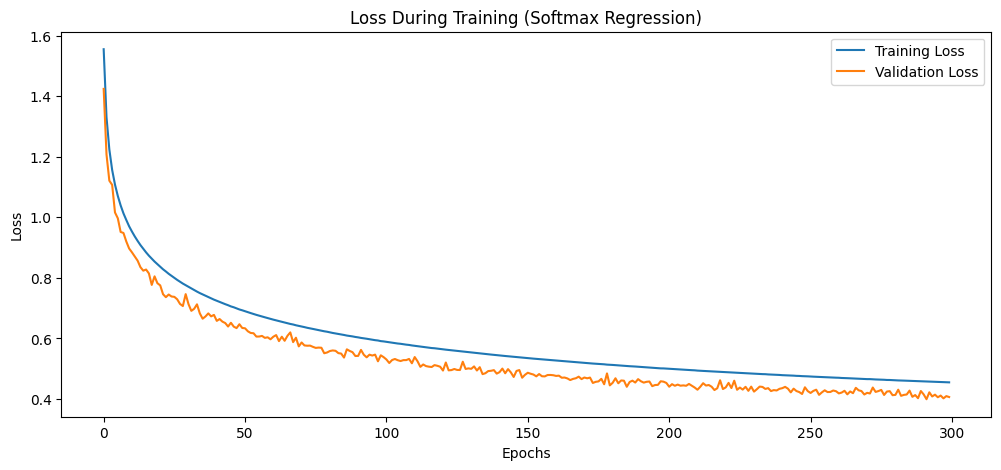

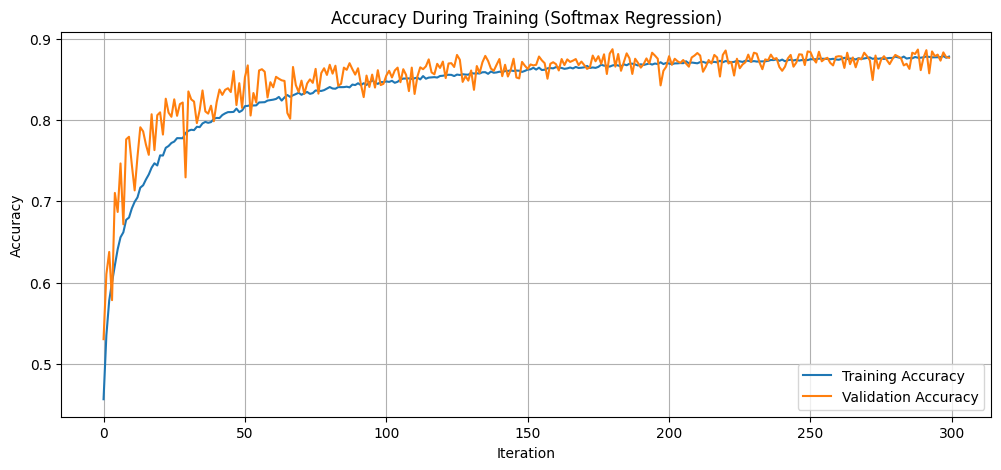

In [23]:
# Vẽ biểu đồ Loss
plt.figure(figsize=(12, 5))
plt.plot(range(softmax_model.n_iter), softmax_model.training_losses, label='Training Loss')
plt.plot(range(softmax_model.n_iter), softmax_model.validation_losses, label='Validation Loss')
plt.title('Loss During Training (Softmax Regression)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


# Vẽ biểu đồ Accuracy
plt.figure(figsize=(12, 5))
plt.plot(range(softmax_model.n_iter), softmax_model.training_accuracies, label='Training Accuracy')
plt.plot(range(softmax_model.n_iter), softmax_model.validation_accuracies, label='Validation Accuracy')
plt.title('Accuracy During Training (Softmax Regression)')
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()

plt.show()

Softmax Regression Accuracy: 0.8694
              precision    recall  f1-score   support

           0       0.95      0.90      0.92       900
           1       0.94      0.94      0.94        31
           2       0.90      0.90      0.90      1021
           3       0.89      0.70      0.78       321
           4       0.69      0.85      0.76       245
           5       0.40      0.90      0.55        48

    accuracy                           0.87      2566
   macro avg       0.79      0.86      0.81      2566
weighted avg       0.89      0.87      0.87      2566



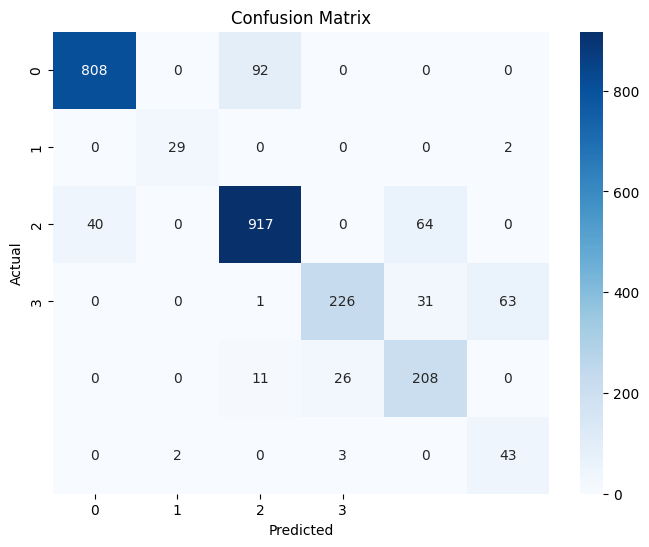

In [24]:
y_pred_softmax = softmax_model.predict(X_test)
accuracy_softmax = accuracy_score(y_test, y_pred_softmax)
print(f"Softmax Regression Accuracy: {accuracy_softmax:.4f}")
print(classification_report(y_test, y_pred_softmax))

cm = confusion_matrix(y_test, y_pred_softmax)

# Hiển thị confusion matrix
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(4), yticklabels=range(4))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [26]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.model_selection import GridSearchCV

# Tập hợp các mô hình và siêu tham số
models = [
    
    ('Decision Tree', DecisionTreeClassifier(), {'max_depth': [10, 20, None], 'min_samples_split': [2, 5]}),
    ('Random Forest', RandomForestClassifier(random_state=42), {'n_estimators': [50, 100], 'max_depth': [10, 20]}),
    ('MLPClassifier', MLPClassifier(max_iter=300, random_state=42), {'hidden_layer_sizes': [(50,), (100,)], 'alpha': [0.0001, 0.001]})
]

# Lặp qua từng mô hình
best_models = []
for name, model, params in models:
    print(f"Tuning {name}...")
    grid = GridSearchCV(model, params, cv=5, scoring='accuracy')
    grid.fit(X_train, y_train)
    best_models.append((name, grid.best_estimator_, grid.best_score_))
    print(f"Best parameters for {name}: {grid.best_params_}")
    print(f"Best cross-validated accuracy for {name}: {grid.best_score_}")

# So sánh các mô hình
for name, model, score in best_models:
    print(f"Model: {name}, Best Accuracy: {score}")


Tuning Decision Tree...
Best parameters for Decision Tree: {'max_depth': None, 'min_samples_split': 2}
Best cross-validated accuracy for Decision Tree: 0.9981610123174868
Tuning Random Forest...
Best parameters for Random Forest: {'max_depth': 20, 'n_estimators': 50}
Best cross-validated accuracy for Random Forest: 0.9983312946467718
Tuning MLPClassifier...


c:\Users\nhatt\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\nhatt\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\nhatt\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\nhatt\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the opti

Best parameters for MLPClassifier: {'alpha': 0.0001, 'hidden_layer_sizes': (100,)}
Best cross-validated accuracy for MLPClassifier: 0.9656384038905239
Model: Decision Tree, Best Accuracy: 0.9981610123174868
Model: Random Forest, Best Accuracy: 0.9983312946467718
Model: MLPClassifier, Best Accuracy: 0.9656384038905239


c:\Users\nhatt\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


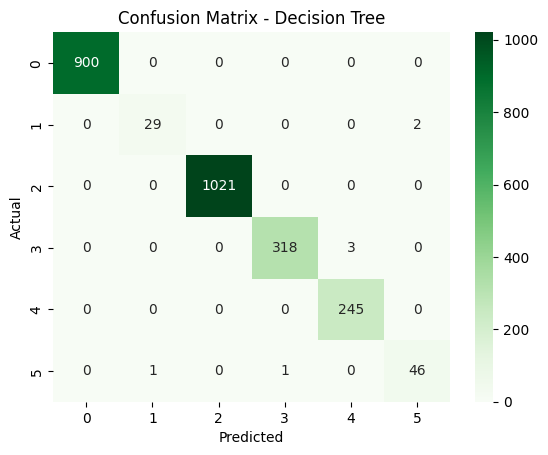

Classification Report - Decision Tree:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       900
           1       0.97      0.94      0.95        31
           2       1.00      1.00      1.00      1021
           3       1.00      0.99      0.99       321
           4       0.99      1.00      0.99       245
           5       0.96      0.96      0.96        48

    accuracy                           1.00      2566
   macro avg       0.98      0.98      0.98      2566
weighted avg       1.00      1.00      1.00      2566



In [27]:
# Khởi tạo mô hình Decision Tree
dt_model = DecisionTreeClassifier(random_state=42, max_depth=5,min_samples_split=2)

# Huấn luyện mô hình
dt_model.fit(X_train, y_train)

# Dự đoán trên tập test
y_pred_dt = dt_model.predict(X_test)

# Ma trận nhầm lẫn
conf_matrix_dt = confusion_matrix(y_test, y_pred_dt)
sns.heatmap(conf_matrix_dt, annot=True, fmt='d', cmap='Greens')
plt.title('Confusion Matrix - Decision Tree')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Báo cáo phân loại
print("Classification Report - Decision Tree:")
print(classification_report(y_test, y_pred_dt))


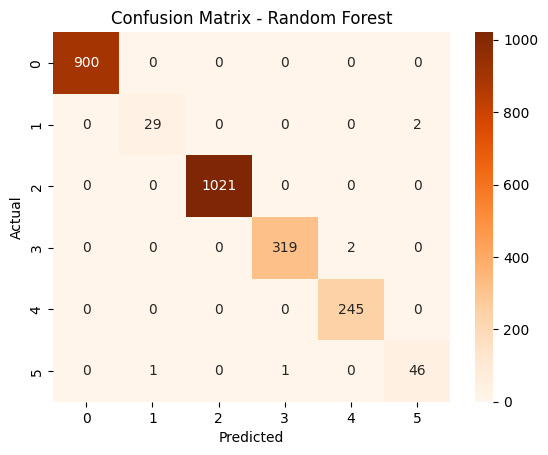

Classification Report - Random Forest:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       900
           1       0.97      0.94      0.95        31
           2       1.00      1.00      1.00      1021
           3       1.00      0.99      1.00       321
           4       0.99      1.00      1.00       245
           5       0.96      0.96      0.96        48

    accuracy                           1.00      2566
   macro avg       0.99      0.98      0.98      2566
weighted avg       1.00      1.00      1.00      2566



In [28]:
# Khởi tạo mô hình Random Forest
rf_model = RandomForestClassifier(n_estimators=50,max_depth=7, random_state=42)

# Huấn luyện mô hình
rf_model.fit(X_train, y_train)

# Dự đoán trên tập test
y_pred_rf = rf_model.predict(X_test)

# Ma trận nhầm lẫn
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(conf_matrix_rf, annot=True, fmt='d', cmap='Oranges')
plt.title('Confusion Matrix - Random Forest')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Báo cáo phân loại
print("Classification Report - Random Forest:")
print(classification_report(y_test, y_pred_rf))


c:\Users\nhatt\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


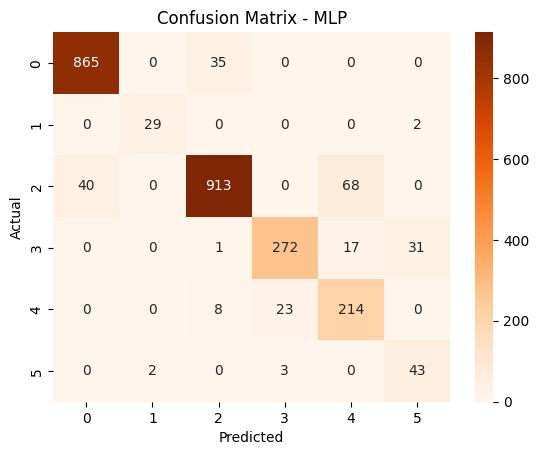

Classification Report - MLP:
              precision    recall  f1-score   support

           0       0.96      0.96      0.96       900
           1       0.94      0.94      0.94        31
           2       0.95      0.89      0.92      1021
           3       0.91      0.85      0.88       321
           4       0.72      0.87      0.79       245
           5       0.57      0.90      0.69        48

    accuracy                           0.91      2566
   macro avg       0.84      0.90      0.86      2566
weighted avg       0.92      0.91      0.91      2566



In [29]:
# Khởi tạo mô hình MLPClassifier
mlp_model = MLPClassifier(hidden_layer_sizes=(10,), max_iter=300,alpha=0.1, random_state=42)

# Huấn luyện mô hình
mlp_model.fit(X_train, y_train)

# Dự đoán trên tập test
y_pred_mlp = mlp_model.predict(X_test)
# Ma trận nhầm lẫn
conf_matrix_mlp = confusion_matrix(y_test, y_pred_mlp)
sns.heatmap(conf_matrix_mlp, annot=True, fmt='d', cmap='Oranges')
plt.title('Confusion Matrix - MLP')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Báo cáo phân loại
print("Classification Report - MLP:")
print(classification_report(y_test, y_pred_mlp))
